In [1]:
# spark must be first found using findspark package
import findspark
findspark.init()

In [2]:
# establish a spark session with 50 executors
from pyspark.sql import SparkSession
spark = SparkSession \
        .builder \
        .master("yarn") \
        .appName("testing") \
        .config("spark.executor.instances", "70") \
        .config("spark.executor.memory","4g") \
        .config("spark.driver.memory","30g") \
        .config("spark.executor.cores",'1') \
        .config("spark.scheduler.mode","FIFO") \
        .getOrCreate()

In [30]:
# import the review dataset
review = spark.read.parquet('/yelp/review.parquet').repartition(300).cache()
business = spark.read.json('/yelp/business.json').repartition(100).cache()

In [4]:
users = spark.read.json('/yelp/user.json').repartition(100)

In [5]:
users.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- fans: long (nullable = true)
 |-- friends: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: str

In [6]:
# take a look at the dataset 
# 1) look at the schema of the data
# 2) count the number of rows
# 3) show a few rows of the dataset
# 4) use the take function to look at the actual values
review.printSchema()
business.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: long (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: boolean (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: struct (nullable = true)
 |    |    |-- casual: boolean (nullable = true)
 |    |    |-- classy: boolean (nullable = true)
 |    |    |-- divey: boolean (nullable = true)
 |    |    |-- hipster: boolean (nullable = true)
 |    |    |-- intimate: boolean (nullable = true)
 |    |    |-- romantic: boolean (nullable = true)
 |    |    |-- touristy: boolean (nullable = true)
 |    |    |-- trendy: boolean (n

In [31]:
review = review.withColumn('totalvotes', review.cool+review.funny+review.useful)

In [33]:
from pyspark.sql.functions import greatest
# select only the reviews where one has at least 50 %
review = review.withColumn('max_vote', greatest(review.cool,review.funny, review.useful))
review = review.where( (review.max_vote / review.totalvotes) >=0.5)
# filter out reviews with less than 10 reviews
#review.where(review.totalvotes>10).count()
review.count()

45361

In [34]:
review = review.where(review.totalvotes > 10)
review.count()

45361

In [35]:
review.select('business_id').distinct().count()
review.select('user_id').distinct().count()

19488

In [9]:
# WORD2VEC model
import time
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec
start = time.time()

# tokenize
tokenizer = Tokenizer(inputCol="text", outputCol="words")
dataset = tokenizer.transform(review)

# drop original text column
dataset = dataset.drop("text")

# Stop word removal
stopremove = StopWordsRemover(inputCol='words',outputCol='cleaned')
dataset = stopremove.transform(dataset)

dataset = dataset.drop('words')

#fit a word2vec model 
word2Vec = Word2Vec(vectorSize=100, minCount=0, numPartitions=300, inputCol="cleaned", outputCol="word2vec")
model = word2Vec.fit(dataset)
dataset = model.transform(dataset).drop('cleaned')

end = time.time()

In [ ]:
#TF-IDF model

In [10]:
dataset=dataset.drop('review_id').cache()

In [75]:
dataset.select('word2vec').count()

45361

In [73]:
from pyspark.ml.feature import PCA

pca = PCA(k=10, inputCol= "word2vec",outputCol="pca_text")
pca_model = pca.fit(dataset)
result = pca_model.transform(dataset).select("pca_text")

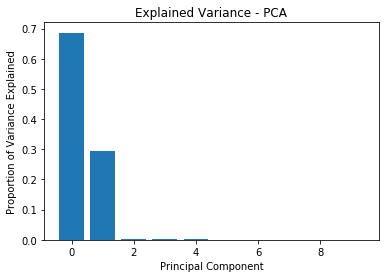

In [104]:
import numpy as np
#np.arange(len(result.columns))
#result.columns
plt.bar(np.arange(len(result.columns)), np.array(pca_model.explainedVariance.values))
plt.title('Explained Variance - PCA')
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.show()

In [99]:
def extract(row):
    return tuple(row.pca_text.toArray().tolist())

result = result.rdd.map(extract).toDF()
result.show()

+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 _1|                 _2|                  _3|                 _4|                  _5|                  _6|                  _7|                  _8|                  _9|                 _10|
+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|-30.418853841330005|-11.655407975416658| -0.3560062345579249| 0.9452881706349798|-0.05096039749258657|-0.00859180070118...|-0.03704309699660682|-0.36623827207988846|-0.05437694628211...| 0.03065929548418997|
|-34.750533026875786|-14.658858635045387| -0.8115435154732529|0.12129296647120702|-0.10262683647707593|-0.35768142279340553|-0.16281451959134474|0.01770435768339184

In [13]:
import plotly.plotly as py
from plotly.graph_objs import *
import pandas as pd
import requests

In [24]:
result.toPandas()

,_1,_2,_3
0,-30.418854,-11.655408,-0.356006
1,-34.750533,-14.658859,-0.811544
2,-33.083126,-14.281905,-0.562658
3,-27.944723,-11.717186,-0.696101
4,-29.584474,-19.131403,-0.691758
5,-17.765374,-12.267815,-0.278009
6,-33.973325,-19.866324,-0.122932
7,-26.687584,-22.260342,-0.215497
8,-34.451625,-12.422050,-0.731364
9,-27.112611,-20.167832,0.285636


In [26]:
result.write.save(format='parquet',path = '/yelp/4741query.parquet')

In [37]:
data = Data([Scatter3d(x=result.toPandas()['_1'],y=result.toPandas()['_2'],z=result.toPandas()['_3'])])

In [39]:
result_pd = result.toPandas()


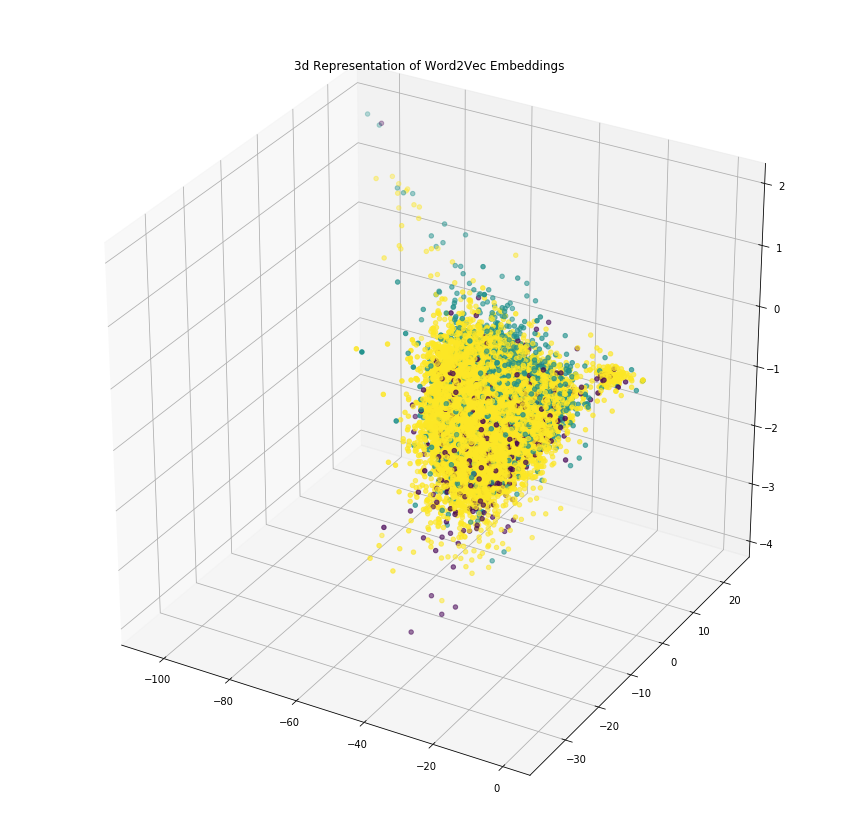

In [105]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111,projection='3d')

ax.scatter(xs=result_pd._1, ys=result_pd._2, zs = result_pd._3, c = result_pd.maxcat_code)
plt.title('3d Representation of Word2Vec Embeddings')
plt.show()

In [77]:
data = dataset.toPandas()

In [90]:
result_pd['maxcat'] = data[['cool','useful','funny']].idxmax(axis = 1 )
result_pd['maxcat'] = result_pd['maxcat'].astype('category')
result_pd['maxcat_code'] = result_pd['maxcat'].cat.codes

In [91]:
result_pd

,_1,_2,_3,maxcat,maxcat_code
0,-30.418854,-11.655408,-0.356006,useful,2
1,-34.750533,-14.658859,-0.811544,useful,2
2,-33.083126,-14.281905,-0.562658,cool,0
3,-27.944723,-11.717186,-0.696101,cool,0
4,-29.584474,-19.131403,-0.691758,useful,2
5,-17.765374,-12.267815,-0.278009,useful,2
6,-33.973325,-19.866324,-0.122932,useful,2
7,-26.687584,-22.260342,-0.215497,useful,2
8,-34.451625,-12.422050,-0.731364,useful,2
9,-27.112611,-20.167832,0.285636,useful,2
